In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
import jax_smi
jax_smi.initialise_tracking()

In [4]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [5]:
from micrlhf.utils.vector_storage import download_vector
layer = 20

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

In [7]:
from micrlhf.utils.mmlu_eval import MMLUEval
mmlu_eval = MMLUEval()

In [8]:
resids = mmlu_eval.get_resids(llama, tokenizer, layer)

  0%|          | 0/4422 [00:00<?, ?it/s]

  0%|          | 0/1474 [00:00<?, ?it/s]

In [9]:
vector_name = "phi3-sycophancy-l20-recon-r5"
vector = download_vector(vector_name, overwrite=True)

In [11]:
from micrlhf.utils.load_sae import get_sae
vector_name = "l20r5 feature 15036"
vector = get_sae(20, 5)["W_dec"][15036]

--2024-08-15 22:40:56--  https://huggingface.co/nev/phi-3-4k-saex-test/resolve/main/l20-test-run-5-7.00E-06/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.51, 108.156.211.125, 108.156.211.90, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.51|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/eb/d8/ebd889d6ac58573e8e8a7aa1176d4d357581a6da60135b94aca378fddf4e9e54/83ac196e9d76d5a3db26b4cc47737ff5c79d3cba0ce3954d02283b9331464948?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1724020857&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDAyMDg1N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2ViL2Q4L2ViZDg4OWQ2YWM1ODU3M2U4ZThhN2FhMTE3NmQ0ZDM1NzU4MWE2ZGE2MDEzNWI5NGFjYTM3OGZkZGY0ZTllNTQvODNhYzE5NmU

In [12]:
x = [[], []]
for vec, correct in resids:
    x[correct].append(float(vec @ vector))

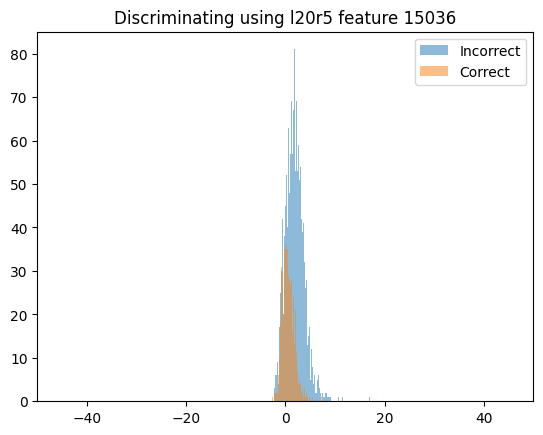

In [13]:
from matplotlib import pyplot as plt
plt.title(f"Discriminating using {vector_name}")
plt.xlim(-50, 50)
plt.hist(x[0], bins=500, alpha=0.5, label="Incorrect")
plt.hist(x[1], bins=500, alpha=0.5, label="Correct")
plt.legend()
plt.show()